In [1]:
# Import libaries
import plotly.graph_objects as go
import copy
import re
import importlib
import pandas as pd

# Import BW25 packages
import bw2data as bd


In [2]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [306]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp

# Reload to reset the state of the self-made libaries
# https://dev.to/fronkan/importlib-reload-for-resting-modules-between-tests-neh
importlib.reload(s)
importlib.reload(MC)
importlib.reload(lc)
importlib.reload(lp)

<module 'LCA_plots' from 'C:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\Libaries\\LCA_plots.py'>

In [4]:
# Specifying if it is CONSQ (consequential) or APOS
db_type = 'CONSQ'

# Specifying the LCIA method
lcia_method = 'recipe'


In [5]:

# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'

# Specifying the file name and sheet name
file_name = f'{path}\Results\Ananas - {db_type}_{lcia_method}.xlsx'
file_cont_name = f'{path}\Results\Ananas contribution - {db_type}_{lcia_method}.xlsx'
sheet_name = 'Ananas'

# Creating the saving directory for the results
save_dir = s.results_folder(path, 'Results', 'Ofir')

# Let the use decide the project and database
database_project, database_name = lc.select_project_and_database()

# Creating the flow legend
flow_legend = ['H2R',
               'H2S',
               'ASC',
               'ASW',
               'H4R',
               'H4S',
               'ALC',
               'ALW'
               ]



Folder name Results created
The chosen project is SU_vs_MU and the chosen database is sterilization


In [6]:
flows = lc.get_database_type_flows(database_project, database_name, db_type)

flows

['H200 REC - CONSQ',
 'H200 SU - CONSQ',
 'H400 REC- CONSQ',
 'H400 SU - CONSQ',
 'alubox large + washer - CONSQ',
 'alubox large + wipe - CONSQ',
 'alubox small + washer - CONSQ',
 'alubox small + wipe - CONSQ']

In [7]:
flows = lc.get_user_specific_flows(database_project, database_name)
flows

choose 'y' if you want to calculate for this flow, and 'n' if not


['H200 REC - CONSQ',
 'H200 SU - CONSQ',
 'H400 REC- CONSQ',
 'H400 SU - CONSQ',
 'alubox large + washer - CONSQ',
 'alubox large + wipe - CONSQ',
 'alubox small + washer - CONSQ',
 'alubox small + wipe - CONSQ']

In [8]:
initialization = [database_project, database_name, flows, lcia_method, db_type]


In [11]:
df, impact_category, plot_x_axis_all, func_unit = lc.calculate_lcia(calculate=True, initialization=initialization, file_name=file_name, sheet_name=sheet_name)

Recipe is selected
Initialization is completed

Calculating the LCA results:
Calculation 1 of 2100 {'market for polypropylene, granulate' (kilogram, GLO, None): 0.07100000000000001} acidification: terrestrial 0.00032945166332279586
Calculation 2 of 2100 {'sheet manufacturing - CONSQ' (kilogram, GLO, None): 0.07100000000000001} acidification: terrestrial 0.00015801064852968925
Calculation 3 of 2100 {'packaging film production, low density polyethylene' (kilogram, RER, None): 0.007274827} acidification: terrestrial 4.638920570989371e-05
Calculation 4 of 2100 {'market for corrugated board box' (kilogram, RER, None): 0.00280226328} acidification: terrestrial 2.0137784910350864e-05
Calculation 5 of 2100 {'autoclave - CONSQ' (unit, GLO, None): 0.08333333333333333} acidification: terrestrial 0.0004521809809624852
Calculation 6 of 2100 {'transport Plastic - CONSQ' (ton kilometer, GLO, None): 0.00358228592} acidification: terrestrial 1.1147787063326353e-06
Calculation 7 of 2100 {'market for pol

In [12]:
redo = False
df = lc.recalculate_lcia(redo, df, initialization, file_name, sheet_name)


In [13]:
rearrange = True
df_rearranged = lc.rearrange_dataframe_index(rearrange, df)
df_rearranged

,"(ReCiPe 2016 v1.03, midpoint (H), acidification: terrestrial, terrestrial acidification potential (TAP))","(ReCiPe 2016 v1.03, midpoint (H), climate change, global warming potential (GWP1000))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: freshwater, freshwater ecotoxicity potential (FETP))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: marine, marine ecotoxicity potential (METP))","(ReCiPe 2016 v1.03, midpoint (H), ecotoxicity: terrestrial, terrestrial ecotoxicity potential (TETP))","(ReCiPe 2016 v1.03, midpoint (H), energy resources: non-renewable, fossil, fossil fuel potential (FFP))","(ReCiPe 2016 v1.03, midpoint (H), eutrophication: freshwater, freshwater eutrophication potential (FEP))","(ReCiPe 2016 v1.03, midpoint (H), eutrophication: marine, marine eutrophication potential (MEP))","(ReCiPe 2016 v1.03, midpoint (H), human toxicity: carcinogenic, human toxicity potential (HTPc))","(ReCiPe 2016 v1.03, midpoint (H), human toxicity: non-carcinogenic, human toxicity potential (HTPnc))",...,"(ReCiPe 2016 v1.03, midpoint (H), land use, agricultural land occupation (LOP))","(ReCiPe 2016 v1.03, midpoint (H), material resources: metals/minerals, surplus ore potential (SOP))","(ReCiPe 2016 v1.03, midpoint (H), ozone depletion, ozone depletion potential (ODPinfinite))","(ReCiPe 2016 v1.03, midpoint (H), particulate matter formation, particulate matter formation potential (PMFP))","(ReCiPe 2016 v1.03, midpoint (H), photochemical oxidant formation: human health, photochemical oxidant formation potential: humans (HOFP))","(ReCiPe 2016 v1.03, midpoint (H), photochemical oxidant formation: terrestrial ecosystems, photochemical oxidant formation potential: ecosystems (EOFP))","(ReCiPe 2016 v1.03, midpoint (H), water use, water consumption potential (WCP))","(ReCiPe 2016 v1.03, endpoint (H), total: ecosystem quality, ecosystem quality)","(ReCiPe 2016 v1.03, endpoint (H), total: human health, human health)","(ReCiPe 2016 v1.03, endpoint (H), total: natural resources, natural resources)"
H200 REC - CONSQ,"[[market for polypropylene, granulate, 0.00032...","[[market for polypropylene, granulate, 0.15424...","[[market for polypropylene, granulate, 0.00257...","[[market for polypropylene, granulate, 0.00349...","[[market for polypropylene, granulate, 0.42468...","[[market for polypropylene, granulate, 0.11757...","[[market for polypropylene, granulate, 1.61076...","[[market for polypropylene, granulate, 1.88960...","[[market for polypropylene, granulate, 0.00351...","[[market for polypropylene, granulate, 0.05867...",...,"[[market for polypropylene, granulate, 0.00170...","[[market for polypropylene, granulate, 0.00015...","[[market for polypropylene, granulate, 1.13904...","[[market for polypropylene, granulate, 0.00014...","[[market for polypropylene, granulate, 0.00029...","[[market for polypropylene, granulate, 0.00031...","[[market for polypropylene, granulate, 0.00111...","[[market for polypropylene, granulate, 5.75758...","[[market for polypropylene, granulate, 2.59989...","[[market for polypropylene, granulate, 0.04791..."
H200 SU - CONSQ,"[[market for polypropylene, granulate, 0.00032...","[[market for polypropylene, granulate, 0.15424...","[[market for polypropylene, granulate, 0.00257...","[[market for polypropylene, granulate, 0.00349...","[[market for polypropylene, granulate, 0.42468...","[[market for polypropylene, granulate, 0.11757...","[[market for polypropylene, granulate, 1.61076...","[[market for polypropylene, granulate, 1.88960...","[[market for polypropylene, granulate, 0.00351...","[[market for polypropylene, granulate, 0.05867...",...,"[[market for polypropylene, granulate, 0.00170...","[[market for polypropylene, granulate, 0.00015...","[[market for polypropylene, granulate, 1.13904...","[[market for polypropylene, granulate, 0.00014...","[[market for polypropylene, granulate, 0.00029...","[[market for polypropylene, granulate, 0.00031...","[[market for polypropylene, granulate, 0.00111...","[[market for poly

In [14]:
if 'recipe' in lcia_method:
    df_test, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
    plot_x_axis_end = plot_x_axis_all[-3:]
    ic_mid = plot_x_axis_all[:-3] 
    plot_x_axis = []
    for ic in ic_mid:
        # print(ic)
        string = re.findall(r'\((.*?)\)', ic)
        plot_x_axis.append(string[0])

else:
    df_test = df_rearranged
    plot_x_axis = plot_x_axis_all


In [15]:
# if calculate_cont == True:
#     sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
#     FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, f'df_idx_ofir_{db_type}', lcia_method, db_type)
#     flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)
#     fu_sub_updated = lc.process_update(FU, functional_unit_sub)
    
#     df_cont = lc.LCIA_contribution(impact_category[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)
#     lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impact_category)
#     df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])


In [262]:
df_tot, df_scaled = lc.dataframe_element_scaling(df_test)
df_col = [df_test.columns[1]]
df_GWP = df_test[df_col]

unique_elements = lc.unique_elements_list(database_name)
colors = s.plot_colors(unique_elements,'turbo')
colors = [
    
    "#789D4A",  # Green
    "#ED5A57",  # Beige
    "#1f77b4",  # Blue 1
    "#A00862",  # Olive
    "#E07E3C",  # Orange
    "#5DADE2",  # Blue 2
    "#E1BBB4",  # Light Pink
    
    "#F2C75C",  # Yellow
    "#C05A57",  # Red
    "#7A6040",  # Brown
    "#2874A6",  # Blue 3
    "#000000"   # Black
]

inputs = [flow_legend, colors, save_dir, db_type, database_name]

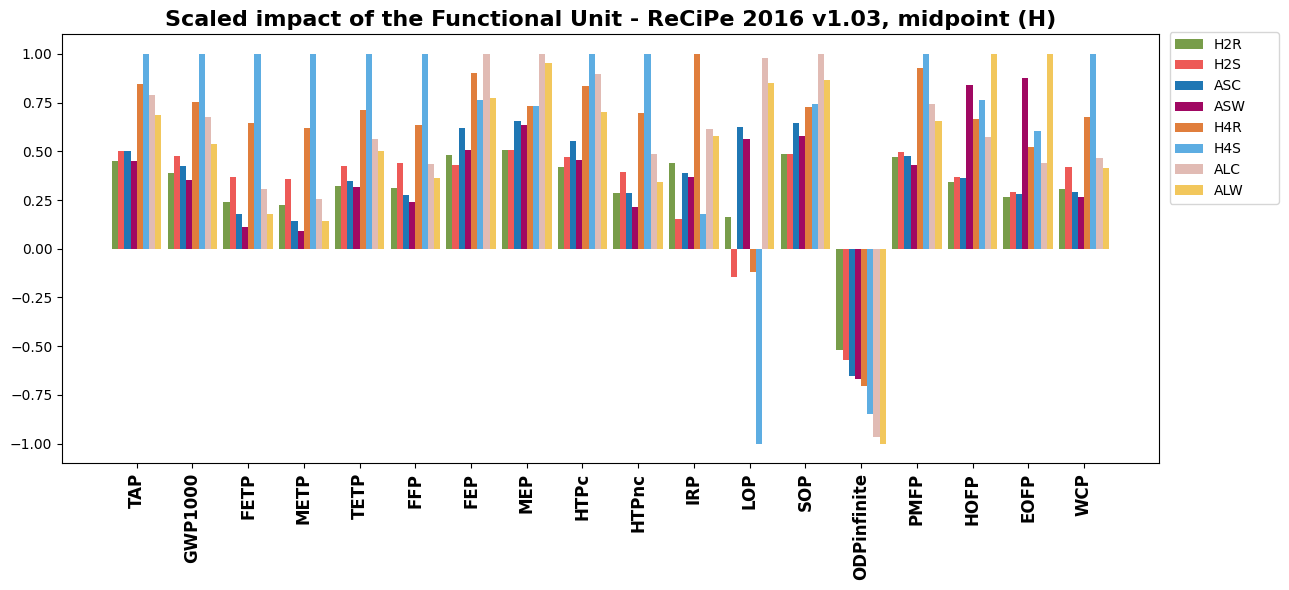

In [263]:
leg_pos_mid = .605

lp.scaled_FU_plot(df_scaled, plot_x_axis, inputs, impact_category, leg_pos_mid)

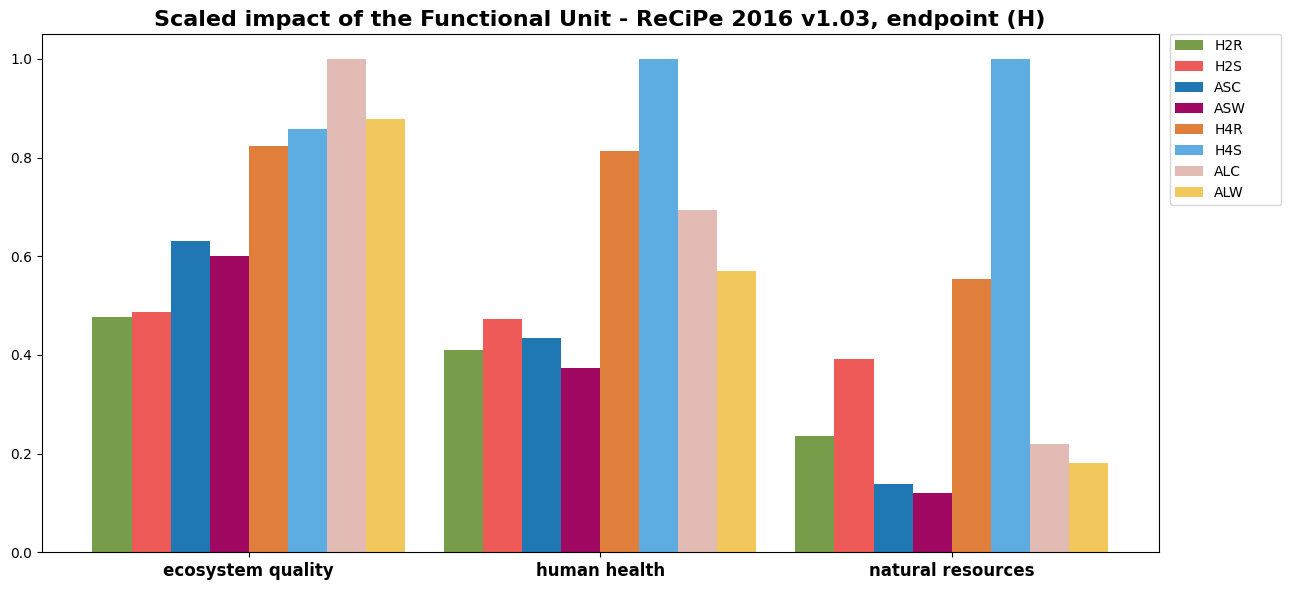

In [264]:
leg_pos_end = 0.67
if 'recipe' in lcia_method.lower():
    df_tot_e, df_scaled_e = lc.dataframe_element_scaling(df_endpoint)
    lp.scaled_FU_plot(df_scaled_e, plot_x_axis_end, inputs, impact_category[-3:], leg_pos_end)


In [265]:
if 'recipe' not in lcia_method:
    directory = 'C:\\Users\\ruw\\Desktop\\RA\\'
    lp.single_score_plot(directory, df_tot, colors, flow_legend, save_dir, db_type)

Total for H200 REC - CONSQ = 0.2842221396061934 kg CO2e
Total for H200 SU - CONSQ = 0.3475147224437328 kg CO2e
Total for alubox small + washer - CONSQ = 0.3116086603371306 kg CO2e
Total for alubox small + wipe - CONSQ = 0.25990278092603203 kg CO2e
Total for H400 REC- CONSQ = 0.5528191431136505 kg CO2e
Total for H400 SU - CONSQ = 0.7336179830871128 kg CO2e
Total for alubox large + washer - CONSQ = 0.4977050496396951 kg CO2e
Total for alubox large + wipe - CONSQ = 0.394293290817498 kg CO2e


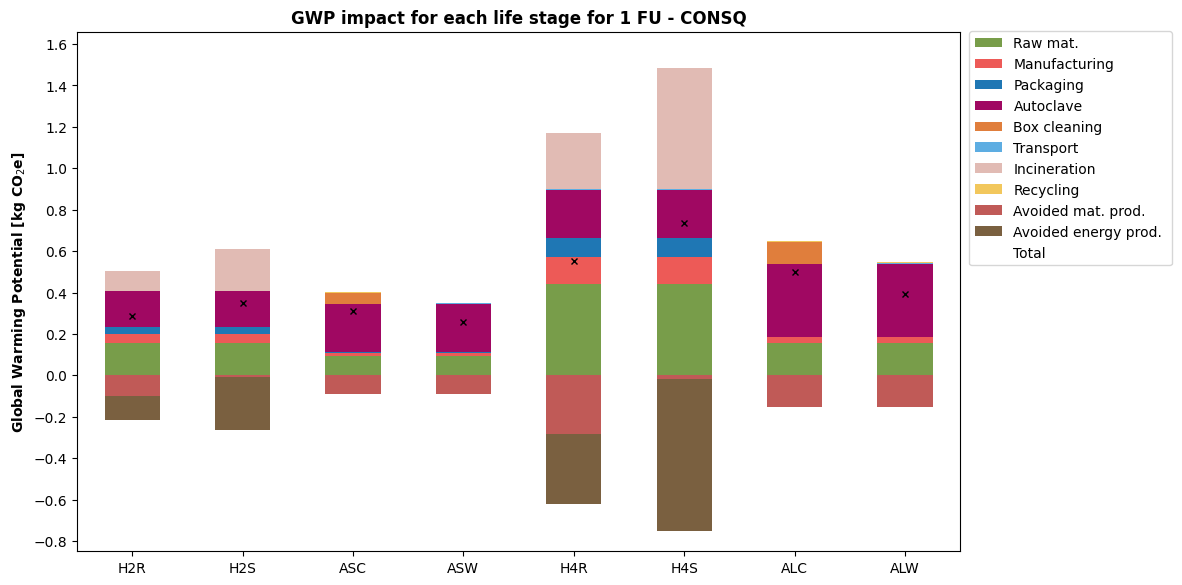

In [266]:

y_min = -0.8
y_max = 1.61
step = 0.2
leg_pos = 0.55
y_axis_values = [y_min, y_max, step, leg_pos]
df_stacked = lp.gwp_scenario_plot(df_GWP, inputs, y_axis_values)


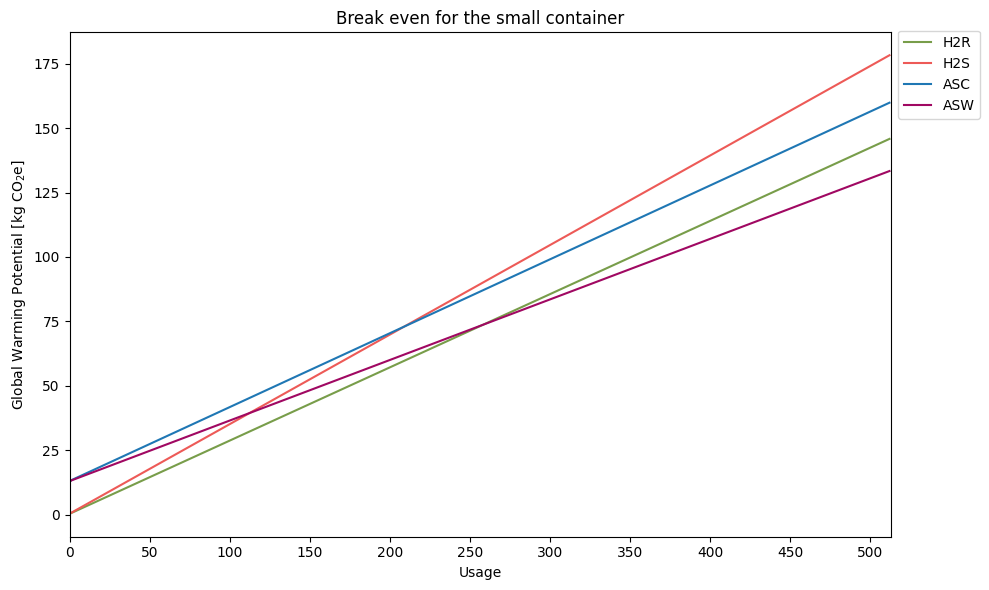

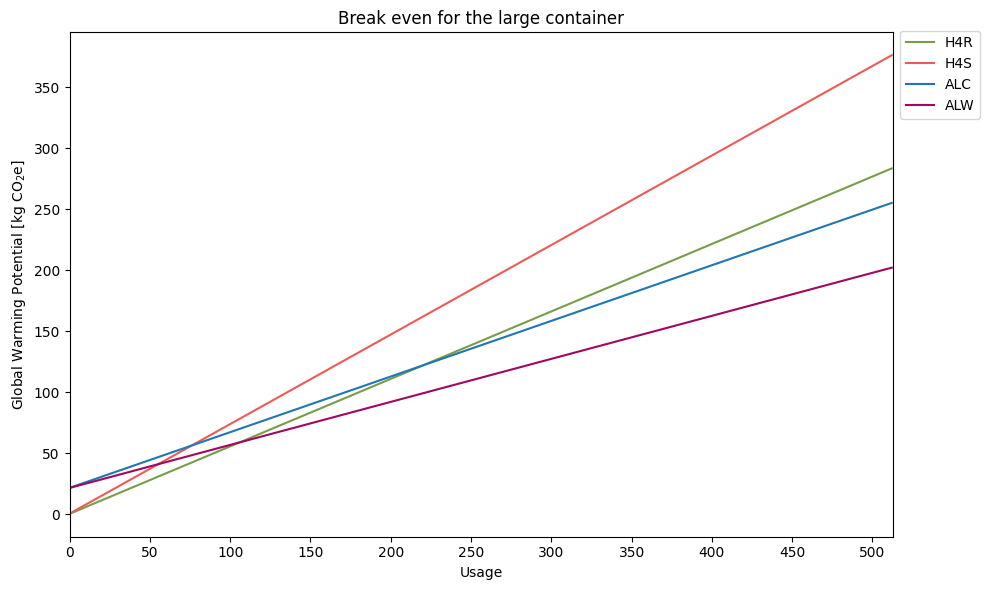

In [307]:
amount_of_uses = 513
lp.break_even_graph(df_stacked, inputs, amount_of_uses)